In [67]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
from sklearn.cluster import DBSCAN


In [68]:
src = '../src/din/'
img = []
for filename in os.listdir(src):
    if 'ppm' in filename:
        img_path = os.path.join(src, filename)
        img.append(cv.imread(img_path))

In [69]:
mat_file = scipy.io.loadmat(f"{src}/cameraCalibration.mat")

print(mat_file.keys())

matrixCalibration = np.array(mat_file['P'][0])

dict_keys(['__header__', '__version__', '__globals__', 'P'])


In [70]:
def extract_intrinsic_matrix(P):
    M = P[:, :3]
    
    M_inv = np.linalg.inv(M)
    
    Q, R = np.linalg.qr(M_inv)
    
    K = np.linalg.inv(R)
    
    K /= K[2, 2]
    
    return np.array(K)

Projection = matrixCalibration.copy()
for i in range(len(matrixCalibration)):
    matrixCalibration[i] = extract_intrinsic_matrix(matrixCalibration[i])

In [76]:
class TwoFrameReconstruction:
    def __init__(self, img1, img2, k1, k2) -> None:
        self.img1   = img1
        self.img2   = img2
        self.k1     = k1
        self.k2     = k2
        self.pts1   = None
        self.pts2   = None
        self.F      = None
        self.E      = None
        self.P1     = None
        self.P2     = None
        self.X      = None
        pass

    def run(self):
        self.correspondences()
        self.fundamental_matrix()
        self.essential_matrix()
        self.camera_matrix()
        self.triangulate()
        return self.X

    def correspondences(self):
        orb = cv.ORB_create()

        kp1, des1 = orb.detectAndCompute(self.img1,None)
        kp2, des2 = orb.detectAndCompute(self.img2,None)

        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

        matches = bf.match(des1,des2)

        matches = sorted(matches, key = lambda x:x.distance)
        img3 = cv.drawMatches(self.img1,kp1,self.img2,kp2,matches[:50],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        # plt.imshow(img3)
        # plt.show()

        self.pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
        self.pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)


    def fundamental_matrix(self):
        self.F, _ = cv.findFundamentalMat(self.pts1, self.pts2, cv.FM_8POINT)

    def essential_matrix(self):
        self.E = self.k2.T @ self.F @ self.k1

    def camera_matrix(self):
        U, S, Vt = np.linalg.svd(self.E)

        if np.linalg.det(U@Vt)<0:
            Vt = -Vt

        R = U @ np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]) @ Vt  
        t = U[:, 2]
        self.P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
        self.P2 = np.hstack((R, t.reshape(-1, 1)))

        self.P1 = self.k1 @ self.P1
        self.P2 = self.k2 @ self.P2

    def triangulate(self):
        X = []
        hom_point1 = np.hstack((self.pts1, np.ones(shape=(self.pts1.shape[0],1))))
        hom_point2 = np.hstack((self.pts2, np.ones(shape=(self.pts2.shape[0],1))))
        n = 50
        for i in range(2*n):
            A = []
            A.append(hom_point1[i][0]*self.P1[2,:] - self.P1[0,:])
            A.append(hom_point1[i][1]*self.P1[2,:] - self.P1[1,:])
            A.append(hom_point2[i][0]*self.P2[2,:] - self.P2[0,:])
            A.append(hom_point2[i][1]*self.P2[2,:] - self.P2[1,:])

            A = np.array(A)
            U, S, Vt = np.linalg.svd(A)
            X.append(Vt.T[:, -1])
            X[-1] /= X[-1][3]

        X = np.array(X)
        self.X = X

    def remove_outliers(self, eps=0.5, min_samples=5):
        points = self.X
        
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
        
        labels = db.labels_
        
        inliers = labels != -1
        
        self.X = self.X[inliers]

---------------------------------------------
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
---------------------------------------------
[[ 9.29737480e+04  5.96322940e+04  5.00479506e+02  3.04911658e+02]
 [ 5.96332940e+04  3.82630374e+04 -1.09339288e+02  1.95589084e+02]
 [ 3.04889396e+02  1.95573969e+02  1.07443118e+01  1.00000000e+00]]
---------------------------------------------
[[ 3.99235688e+00  3.94176810e+01 -7.63289880e-01  3.95917551e+00]
 [-1.44302310e+01 -9.41441580e-01 -2.74509701e+01 -1.44294334e+01]
 [ 1.22492404e-02 -1.45746038e-04 -5.69307087e-04  1.22493587e-02]]
---------------------------------------------
[[ 1.07732491e+01  3.81264946e+01 -7.63289880e-01  3.95917551e+00]
 [-1.43746181e+01  1.57741398e+00 -2.74509701e+01 -1.44294334e+01]
 [ 1.20380326e-02 -2.26955972e-03 -5.69307087e-04  1.22493587e-02]]
---------------------------------------------
---------------------------------------------
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
--------------------------

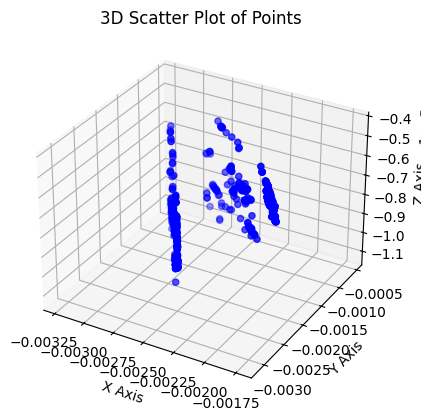

In [72]:
X = None
for i in range(2):
    img1 = img[i]
    img2 = img[i+1]

    cal1 = matrixCalibration[i]
    cal2 = matrixCalibration[i+1]

    tfr = TwoFrameReconstruction(img1, img2, cal1, cal2)
    tfr.run()
    
    if X is None:
        X = tfr.X
    else:
        X = np.vstack((X, tfr.X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = X[:, 0]
y = X[:, 1]
z = X[:, 2]

ax.scatter(x, y, z, c='b', marker='o')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

ax.set_title('3D Scatter Plot of Points')

plt.show()

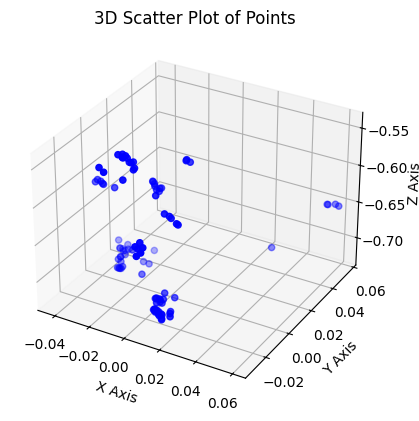

In [77]:
X = None
for i in range(10):
    img1 = img[i]
    img2 = img[i+1]

    cal1 = Projection[i]
    cal2 = Projection[i+1]

    tfr = TwoFrameReconstruction(img1, img2, None, None)
    tfr.correspondences()
    tfr.P1 = cal1
    tfr.P2 = cal2
    tfr.triangulate()
    tfr.remove_outliers()
    if X is None:
        X = tfr.X
    else:
        X = np.vstack((X, tfr.X))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = X[:, 0]
y = X[:, 1]
z = X[:, 2]

ax.scatter(x, y, z, c='b', marker='o')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

ax.set_title('3D Scatter Plot of Points')

plt.show()
